In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing import image

In [296]:
# import the datasets
train_dir = "./dataset/train"
test_dir = "./dataset/test"

Emotions = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', "Surprised"]

In [297]:
# import hashlib
# import os
# from PIL import Image

# # Check for duplicates and remove
# def remove_duplicates(duplicates):
#     for duplicate, original in duplicates:
#         os.remove(duplicate)  # Remove the duplicate file

# def hash_image(image_path):
#     with Image.open(image_path) as img:
#         hash_value = hashlib.md5(img.tobytes()).hexdigest()
#     return hash_value

# def find_duplicates(directory):
#     hash_dict = {}
#     duplicates = []
#     for subdir, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(subdir, file)
#             file_hash = hash_image(file_path)
#             if file_hash in hash_dict:
#                 duplicates.append((file_path, hash_dict[file_hash]))
#             else:
#                 hash_dict[file_hash] = file_path
#     return duplicates

# duplicates = find_duplicates(train_dir)
# print(f"Found {len(duplicates)} duplicate images.")

# remove_duplicates(duplicates)

# train_dir = "./dataset/train"
# test_dir = "./dataset/test"

In [298]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   validation_split = 0.25,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.25)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 64,
                                                    shuffle  = True, 
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed=12)

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                        target_size = (48,48),
                                                        batch_size = 64,
                                                        shuffle  = False, 
                                                        color_mode = "grayscale",
                                                        class_mode = "categorical",
                                                        subset = "validation",
                                                        seed=12)

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  batch_size = 64,
                                                  shuffle  = False, 
                                                  color_mode = "grayscale",
                                                  class_mode = "categorical",
                                                  seed=12)

Found 20606 images belonging to 7 classes.
Found 6867 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


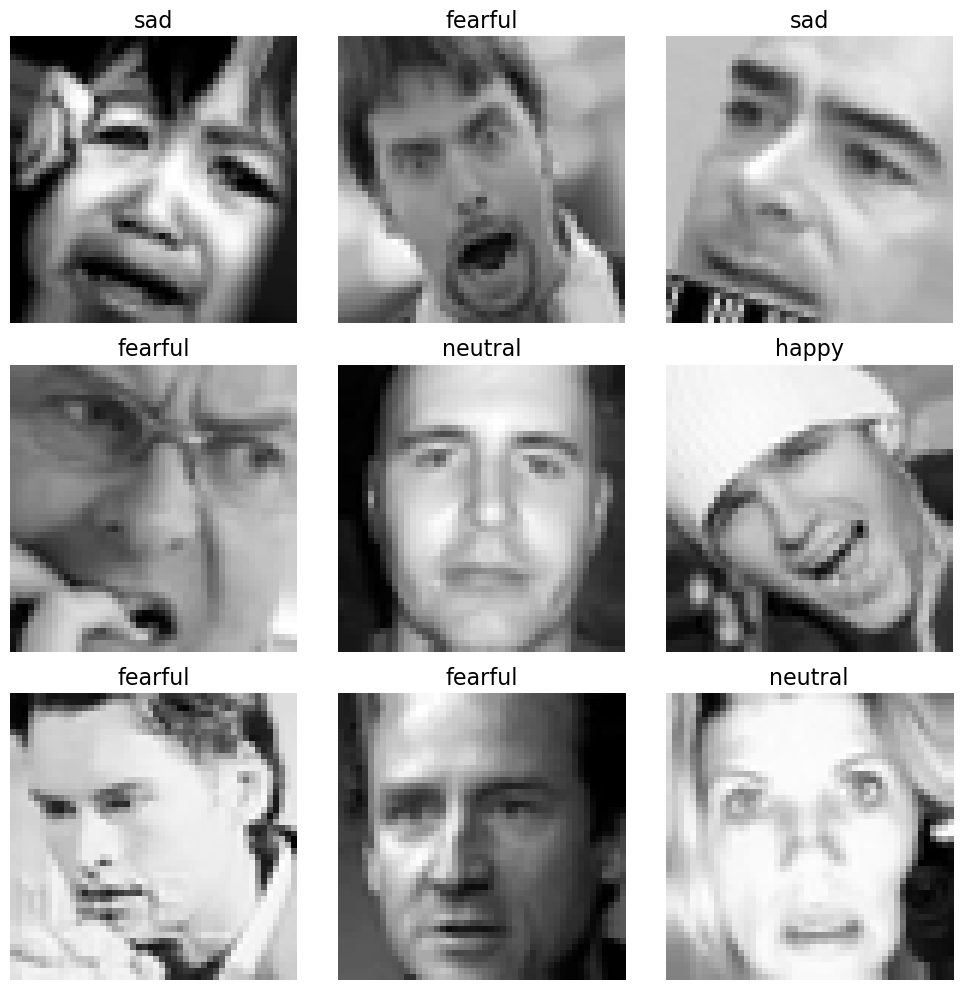

In [299]:
# Function to plot images
def display_images_with_labels(images, labels, class_labels):
    # Convert labels to class names
    class_indices = np.argmax(labels, axis=-1)  # Get class indices from one-hot labels
    titles = [class_labels[idx] for idx in class_indices]  # Convert indices to class names
    
    # Plot 9 images in a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for img, title, ax in zip(images[:9], titles[:9], axes):
        ax.imshow(img.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
        ax.set_title(title, fontsize=16)
        ax.axis('off')  # Hide axis
        
    plt.tight_layout()
    plt.show()

# Retrieve a batch of images and labels
images, labels = next(train_generator)

# Get class labels from train_generator
class_labels = list(train_generator.class_indices.keys())

# Display 9 images with labels
display_images_with_labels(images, labels, class_labels)

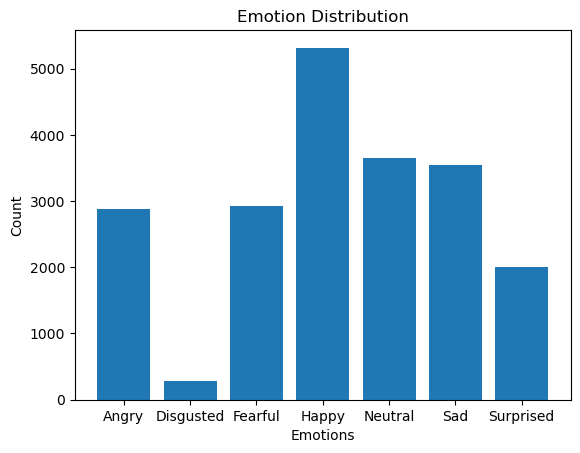

In [300]:
# class distribution
plt.bar(Emotions, [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)])
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.show()

In [301]:
from sklearn.utils.class_weight import compute_class_weight

# balance the class distribution using weights
classes = np.unique(train_generator.classes)
y = train_generator.classes
class_weights = compute_class_weight('balanced', classes=classes, y=y)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

class_weights_gen = {0: 1.0, 1: 5.0, 2: 1.0, 3: 0.5, 4: 0.8, 5: 0.8, 6: 1.0}

{0: 1.0196447127517443, 1: 10.292707292707293, 2: 1.005366900858704, 3: 0.5538502889396586, 4: 0.8062761669992565, 5: 0.8322630154691223, 6: 1.4703867561010417}


In [302]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation

# build CNN model
model = Sequential()

# feature extraction
model.add(Conv2D(32,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(Activation('relu')) # non-linear features
model.add(MaxPooling2D(pool_size=(2, 2))) # extract max features
model.add(BatchNormalization()) # stabilize

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu')) # non-linear features
model.add(MaxPooling2D(pool_size=(2, 2))) # extract max features
model.add(BatchNormalization()) # stabilize

model.add(Conv2D(128,(3,3), padding='same'))
model.add(Activation('relu')) # non-linear features
model.add(MaxPooling2D(pool_size=(2, 2))) # extract max features
model.add(BatchNormalization()) # stabilize

model.add(Conv2D(256,(3,3), padding='same'))
model.add(Activation('relu')) # non-linear features
model.add(MaxPooling2D(pool_size=(2, 2))) # extract max features
model.add(BatchNormalization()) # stabilize

model.add(Flatten()) # reduce dimensionality

# Neuron connections
model.add(Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Activation('relu')) # non-linear features
model.add(BatchNormalization()) # stabilize
model.add(Dropout(0.25)) # random reduction

model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Activation('relu')) # non-linear features
model.add(BatchNormalization()) # stabilize
model.add(Dropout(0.25)) # random reduction

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Piper\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_128 (Conv2D)             │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_144 (Activation)     │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_128               │ (None, 24, 24, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_191         │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_145 (Activation)     │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_129               │ (None, 12, 12, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_192         │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_146 (Activation)     │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_130               │ (None, 6, 6, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_193         │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_147 (Activation)     │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_131               │ (None, 3, 3, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_194         │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_148 (Activation)     │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_195         │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,019,399 (11.52 MB)

 Trainable params: 3,015,879 (11.50 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [303]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=5,
                                                        verbose=1,
                                                        restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

epochs = 30

history = model.fit(
    x=train_generator,
    epochs=epochs,
    class_weight = class_weights_gen,
    validation_data = validation_generator,
    callbacks= [earlyStoppingCallback, lr_schedule])

history = pd.DataFrame(history.history)



Epoch 1/30


c:\Users\Piper\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 159ms/step - accuracy: 0.2062 - loss: 2.5518 - val_accuracy: 0.2165 - val_loss: 2.5654 - learning_rate: 5.0000e-04
Epoch 2/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step - accuracy: 0.3328 - loss: 2.0924 - val_accuracy: 0.4088 - val_loss: 2.0667 - learning_rate: 5.0000e-04
Epoch 3/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - accuracy: 0.4121 - loss: 1.8690 - val_accuracy: 0.3922 - val_loss: 2.0734 - learning_rate: 5.0000e-04
Epoch 4/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - accuracy: 0.4591 - loss: 1.7095 - val_accuracy: 0.4676 - val_loss: 1.7937 - learning_rate: 5.0000e-04
Epoch 5/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.4840 - loss: 1.6047 - val_accuracy: 0.4785 - val_loss: 1.7387 - learning_rate: 5.0000e-04
Epoch 6/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.5074 - loss: 1.5156 - val_accuracy: 0.4983 - val_loss: 1.6659 - learning_rate: 5.0000e-04
Epoch 7/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - 

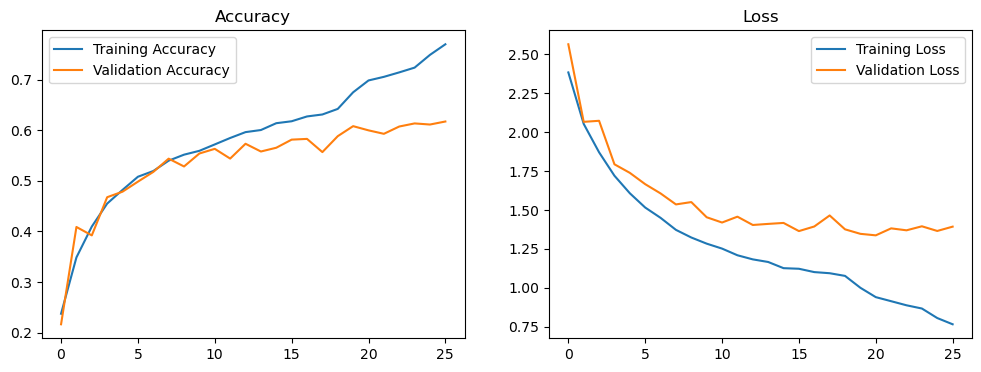

In [304]:
# plot training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()